In [1]:
import pandas as pd
import numpy as np
import scoring as sc

from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression as lr
import sklearn.metrics as metrics

In [2]:
df=pd.read_csv('gc.csv')
vardict=pd.read_csv('dict.csv')
df['Risk']=df['Risk'].apply(lambda x: 1 if x=='bad' else 0)
df=sc.renameCols(df,vardict,False)
label,disc,cont=sc.getVarTypes(vardict)
# sc.discSummary(df)

# ### No row needs to be removed from this example in this stage ###
# vardict.loc[vardict['new'].isin(['Age','Sex']),'isDel']=1
# df,vardict=cl.delFromVardict(df,vardict)

In [3]:
df1=sc.binData(df,vardict)

#########################################
####It's using Chi-Merge algorithm...####
#########################################

Doing continous feature: Age

Doing continous feature: Credit amount
Equal Depth Binning is required, number of bins is: 100

Doing continous feature: Duration

Doing discrete feature: Sex

Doing discrete feature: Job

Doing discrete feature: Housing

Doing discrete feature: Saving accounts

Doing discrete feature: Checking account

Doing discrete feature: Purpose

Finished


In [6]:
bidict=sc.getBiDict(df1,label)

In [7]:
bidict['Credit amount']

,Credit amount,total,good,bad,totalDist,goodDist,badDist,goodRate,badRate,woe,iv
0,"(-inf, 1282.0]",211,144,67,0.211,0.223,0.206,0.682,0.318,-0.082,0.001
1,"(1282.0, 3446.32]",469,352,117,0.469,0.390,0.503,0.751,0.249,0.254,0.029
2,"(3446.32, 3913.26]",60,55,5,0.060,0.017,0.079,0.917,0.083,1.551,0.096
3,"(3913.26, inf]",260,149,111,0.260,0.370,0.213,0.573,0.427,-0.553,0.087


In [23]:
# modified credit amount
sc.bivariate(pd.DataFrame({'y':df['y'],
                           'Credit amount':sc.manuallyBin(df,
                                                          'Credit amount',
                                                          'cont',
                                                          [-np.inf,1300,3500,4000,np.inf])}
                         ),'Credit amount','y')[0]
df1['Credit amount']=sc.manuallyBin(df,'Credit amount','cont',[-np.inf,1300,3500,4000,np.inf])

In [25]:
bidict=sc.getBiDict(df1,label)
ivtable=sc.ivTable(bidict)

In [27]:
df1,vardict,bidict=sc.featureFilter(df1,vardict,bidict,ivtable)

In [28]:
df1=sc.mapWOE(df1,bidict,label)

In [29]:
### Modelling ###
#################
trainx,testx,trainy,testy=tts(df1.iloc[:,1:],df1[label],test_size=0.3)
m=lr(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
m.fit(trainx,trainy)
pred=m.predict(testx)
pred_prob=m.predict_proba(testx)[:,1]

# 查看测试结果
cm=metrics.confusion_matrix(testy, pred)
print('**Precision is:',(cm[0][0]+cm[1][1])/(sum(cm[0])+sum(cm[1])))
print('\n**Confusion matrix is:\n',cm)
print('\n**Classification report is:\n',metrics.classification_report(testy, pred))

**Precision is: 0.7233333333333334

**Confusion matrix is:
 [[179  18]
 [ 65  38]]

**Classification report is:
               precision    recall  f1-score   support

           0       0.73      0.91      0.81       197
           1       0.68      0.37      0.48       103

   micro avg       0.72      0.72      0.72       300
   macro avg       0.71      0.64      0.64       300
weighted avg       0.71      0.72      0.70       300



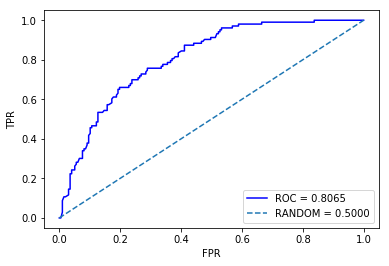

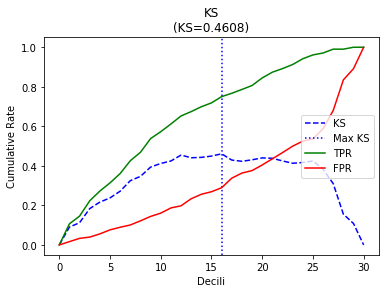

Confusion matrix, without normalization
[[179  18]
 [ 65  38]]


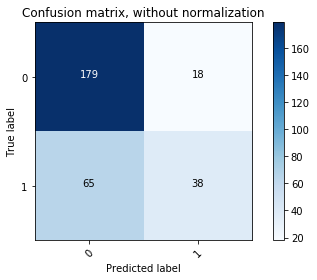

In [30]:
### Evaluation ###
##################
sc.plotROC(testy,pred_prob)
sc.plotKS(testy,pred_prob)
sc.plotCM(metrics.confusion_matrix(testy,pred), classes=df[label].unique(),
          title='Confusion matrix, without normalization')

In [31]:
### Scoring ###
###############
scored,basescore=sc.scoring(trainx.reset_index(drop=True),
                            trainy.reset_index(drop=True),
                            'y',
                            m,
                            bidict)